# METROID - Morphological Equal-area Technique for Regions of Interest Denoising

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import sys,os
metroidpath = 'C:\\Users\\Marcelo\\Documents\\ia898new\\ROI analyzer\\Profluo (default regions)\\METROID'
if metroidpath not in sys.path:
    sys.path.append(metroidpath)


In [2]:
metroidpath

'C:\\Users\\Marcelo\\Documents\\ia898new\\ROI analyzer\\Profluo (default regions)\\METROID'

In [13]:
fpath = 'C:\\Users\\Marcelo\\Documents\\ia898new\\ROI analyzer\\Profluo (default regions)\\METROID\\Data\\Cell1\\video_EP'
# fr_list = [55.78, 55.78, 55.78, 55.67] #Cell2
# fr_list = [71.29, 71.29, 71.29, 71.15] #Cell1
fr_list = [71.29]
# mpath = fpath + '\\cellmasks'
transitory=False
t_sig_onset = 2.5
t_sig_end = None
method = 'wPCA'
n_comp=2
wavelet = 'Haar'
autoselect='manual'

In [14]:
def metroid(folder,FR,transitory,t_sig_onset=None,t_sig_end=None,method='wPCA',n_comp=2,wavelet='Haar',autoselect='auto'):
    video_list = get_img_stacks(folder)
    mask_list = load_masks(video_list, folder)
    while(len(video_list)>len(mask_list)):
        mask_list.append(mask_list[0])
    
    from ipynb.fs.full.MES import mes
    ROIs_means_list = []
    for video,fr,mask in zip(video_list,FR,mask_list):
#         print('LAK')
        ROIs_msk, ROIs_means, time  = mes(video, fr, mask)
        ROIs_means_list.append(ROIs_means)
    if len(video_list)>1:
#         print(len(ROIs_means_list))
        ROIs_means = np.mean(ROIs_means_list,axis=0)
#         print(ROIs_means.shape)
        FR = np.mean(FR)
        video = video_list[-1]
        mask = mask_list[-1]
        from ipynb.fs.full.MES import build_time_vector
        time = build_time_vector(fr,video.shape)
    
#     print(video.shape,time.shape,mask.shape,ROIs_means.shape)
    from ipynb.fs.full.Remove_photobleaching import photob_remove    
    ROIs_means_corrected, corrections, inactive_msk,t_sig_onset  = photob_remove(video,time, mask,ROIs_means,transitory,t_sig_onset,t_sig_end)
#     print(t_sig_onset)
    if transitory==None:
        return(ROIs_msk,None,time,ROIs_means,ROIs_means_corrected,corrections,mask_list)
    from ipynb.fs.full.BSSD import BSSD
    ROIs_filtered,sources,selected_source_idx = BSSD(ROIs_means_corrected,time,inactive_msk,t_sig_onset,method,n_comp,wavelet,autoselect)
    return(ROIs_msk,ROIs_filtered,time,ROIs_means,ROIs_means_corrected,corrections,mask_list,sources,selected_source_idx)

In [15]:
def get_img_stacks(folder):
    '''Gets image stacks in .tif format
       Stacks order should be defined by the last character in each name'''
    from skimage import io
    import os
    items = os.listdir(folder)
    stacks_names = []
    fext='.tif'
    for fname in items:
        if fname.endswith(fext):
            stacks_names.append(fname)
    if stacks_names==[]:
        print("No .tif files found in ", folder)
        return
    else:
        def last_character(name):
            return name[-5]
        stacks_names.sort(key=last_character)

        video_list = []
        for fname in stacks_names:
            fullpath = folder + '\\' + fname
            f = io.imread(fullpath)
            if len(f.shape)>2: #Get only videos, single images are not included
                video_list.append(f)
        return(video_list)

In [16]:
def load_masks(video_list,folder=None):
    '''Load cell masks from dir
       Cell masks should be binary images with the same shape (lin, col) as the videos
       If there are no cell masks, this function produces an approximated cell mask for each video'''
    import numpy as np
    from skimage import io
    import os
    #If masks are not provided, generate masks by adding first images until any pixel saturation
    if folder==None:
        from skimage.filters import threshold_otsu, threshold_local
        from skimage.morphology import remove_small_objects
        from skimage.segmentation import clear_border
        import scipy.ndimage as sm
        n_sum_til_saturation = []
        for v in video_list:
            f0mean = np.mean(v[0])
            temp = (2**16)//f0mean
            n_sum_til_saturation.append(temp.astype(int))
            
        
        f_satlist = []
        b_satlist = []
        for n,v in zip(n_sum_til_saturation,video_list):
            f_sat = np.zeros_like(v[0],dtype='uint32')
            b_sat = np.zeros_like(v[0],dtype='bool')
            
            #adds first images pixel to pixel
            for j in range(n-1):
                f_sat = np.add(f_sat,v[j])
                
            sat_values = f_sat>65535
            f_sat[sat_values] = 65535
            
            
            f_sat = sm.gaussian_filter(f_sat,sigma=2)

            f_satlist.append(f_sat.astype('uint16'))
            block_size = 99
            thresh = threshold_local(f_sat, block_size, offset=0)
            b_sat = f_sat > thresh

            b_sat = sm.binary_closing(b_sat,iterations=1)
            b_sat = sm.binary_fill_holes(b_sat)
            b_sat = remove_small_objects(b_sat,500)

            
            # removes artifacts connected to image border
            b_sat = clear_border(b_sat)
            
            b_satlist.append(b_sat.astype(bool))
    else:
        items = os.listdir(folder)
        stacks_names = []
        fext='.tif'
        for fname in items:
            if fname.endswith(fext):
                stacks_names.append(fname)
        # checks whether there are .tif files in directory
        if stacks_names==[]:
            print("No .tif files found in ", folder)
            return
        else:
            def last_character(name):
                return name[-5]
            stacks_names.sort(key=last_character)
            b_satlist = []
            for fname in stacks_names:
                fullpath = folder + '\\' + fname
                b = io.imread(fullpath)
                if len(b.shape)<3:
                    b_satlist.append(b.astype(bool)) 
    return(b_satlist)

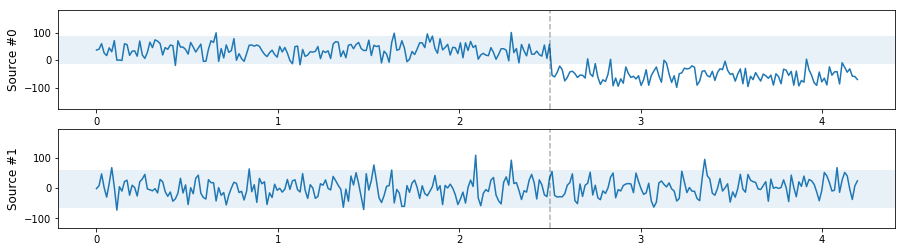

Enter one or more sources number (separate numbers by "," if number of sources > 1): 0


In [17]:
ROIs_mask,ROIs_filtered,time,ROIs_means,ROIs_means_corrected,corrections,mask_list,sources,selected_source_idx = metroid(fpath,fr_list,transitory,t_sig_onset,t_sig_end,method,n_comp,wavelet,autoselect)

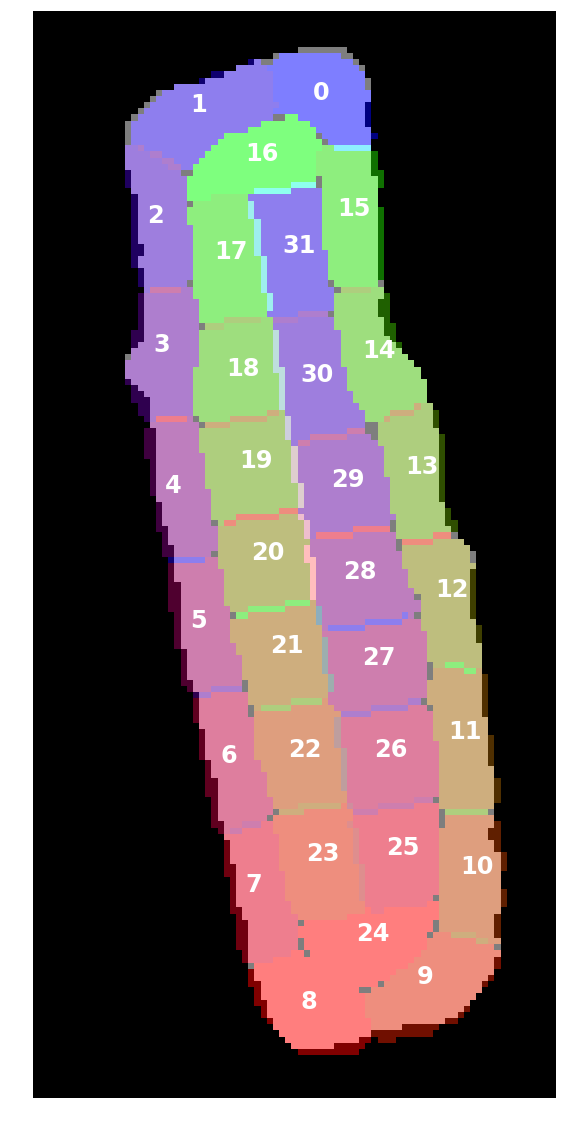

In [8]:
segments = ROIs_mask[0:ROIs_mask.shape[0]//2,:,:]
slices = ROIs_mask[ROIs_mask.shape[0]//2:,:,:]
mask = mask_list[0]
def get_centroid(msk):
    '''Get central point of shape'''
    from skimage.measure import label, regionprops
    label_img = label(msk)
    regions = regionprops(label_img)
    for props in regions:
        y0, x0 = props.centroid
    return(x0, y0)
fig, ax = plt.subplots(figsize=[15,20],nrows=1, ncols=1)
#     row=0
#     col=0
#     for s,ss,m in zip(segments_list,slices_list,msklist):
segment_rgb = np.zeros((segments.shape[1],slices.shape[2],3))
nregions = segments.shape[0]


cent_coord = np.zeros((nregions,2))
cent_coord2 = np.zeros((nregions,2))
for j in range(nregions):
    r = j/(nregions//2)
    b = 1 - r
    g = 0
    if(j>nregions//2):
        g = (j-nregions//2)/(nregions//2)
        b = 0
        r = 1 - g  


    segment_rgb[:,:,0] = segment_rgb[:,:,0] + r*segments[j,:,:] + r*slices[j,:,:]
    segment_rgb[:,:,1] = segment_rgb[:,:,1] + g*segments[j,:,:] + b*slices[j,:,:]
    segment_rgb[:,:,2] = segment_rgb[:,:,2] + b*segments[j,:,:] + g*slices[j,:,:]
    cent_coord[j,:] = np.rint(get_centroid(segments[j,:,:]))
    cent_coord2[j,:] = np.rint(get_centroid(slices[j,:,:]))
ax.imshow(segment_rgb)
for j in range(nregions):
    k = j
    ax.annotate(k,(cent_coord[j,0]-2,cent_coord[j,1]),xycoords='data',color='white',fontsize=24,weight='bold')
for j in range(nregions):
    k = j+nregions
    ax.annotate(k,(cent_coord2[j,0]-2,cent_coord2[j,1]),xycoords='data',color='white',fontsize=24,weight='bold')
ax.axis('off')
#     pathtemp = 'C:/Users/Marcelo/Desktop/Artigo modelo filtragem/graph data to plot/'
#     plt.savefig(pathtemp+'graph_regions.tiff',bbox_inches='tight',pad_inches=0,dpi=600)
ax.imshow(mask,alpha=0.5,cmap='gray')
#     col+=1
#         if col>1:
#             col=0
#             row+=1

(0, 15)

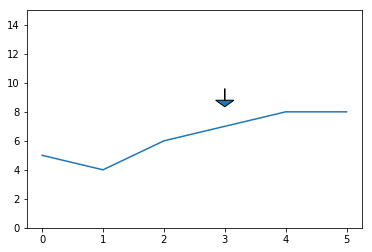

In [17]:
A = np.array([0,1,2,3,4,5])
B = np.array([5,4,6,7,8,8])
plt.plot(A,B)
y = 1.2*np.amax(B)
dy = -0.1*np.amax(B)
width=0.001
plt.arrow(3,y,0,dy,width=0.001,head_width=300*width)
plt.ylim(0,15)

In [9]:
corrections

{'exp': array([], dtype=int64),
 'exp&lin': array([ 1,  2,  3,  4,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        21, 24, 25, 26, 28, 29, 30, 31], dtype=int64),
 'lin': array([ 0,  5,  6, 20, 22, 23, 27], dtype=int64)}

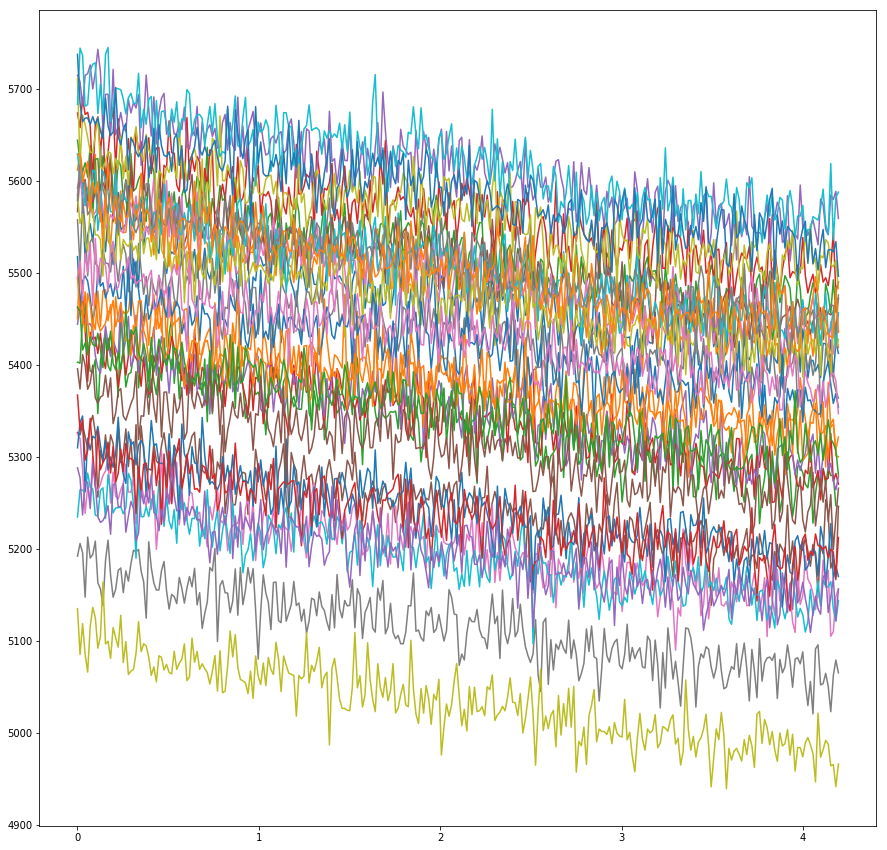

In [10]:
plt.figure(figsize=[15,15])
plt.plot(time, ROIs_means)

[ 2.69125333e-12  2.36348032e-01 -4.04482535e-04  8.08754944e-02
 -2.29840643e-01  1.96791251e-13  1.42008822e-12  2.62291078e-01
 -1.79213982e-01 -3.83739823e-01  1.72122909e-01 -2.55124252e-01
  1.93983121e-01 -1.96193792e-01  1.19804685e-01  1.32373539e-01
  1.50325497e-01  3.52084297e-01 -5.07054198e-01  6.29971663e-02
  2.80294566e-12 -3.59758203e-01  1.44668163e-12  7.55252910e-13
  4.22110912e-01 -2.54477847e-01 -1.74324555e-01  6.86110038e-13
  8.04125441e-02  1.47493432e-01  6.93699200e-02 -7.89281436e-02]


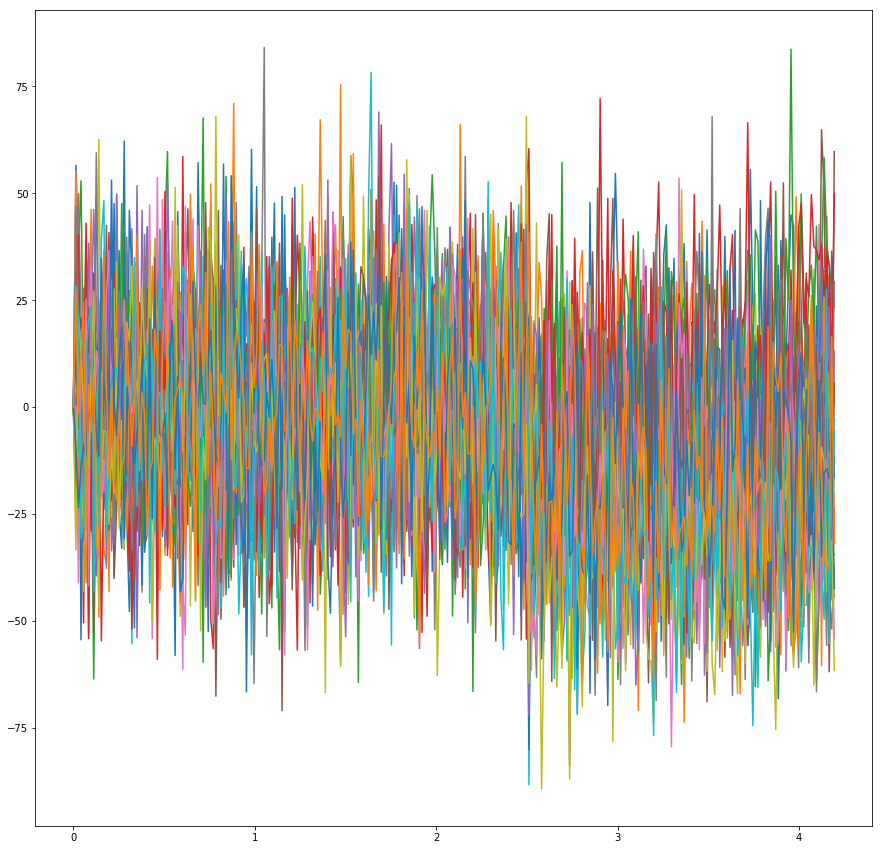

In [11]:
plt.figure(figsize=[15,15])
plt.plot(time, ROIs_means_corrected)
print(ROIs_means_corrected[0,:])

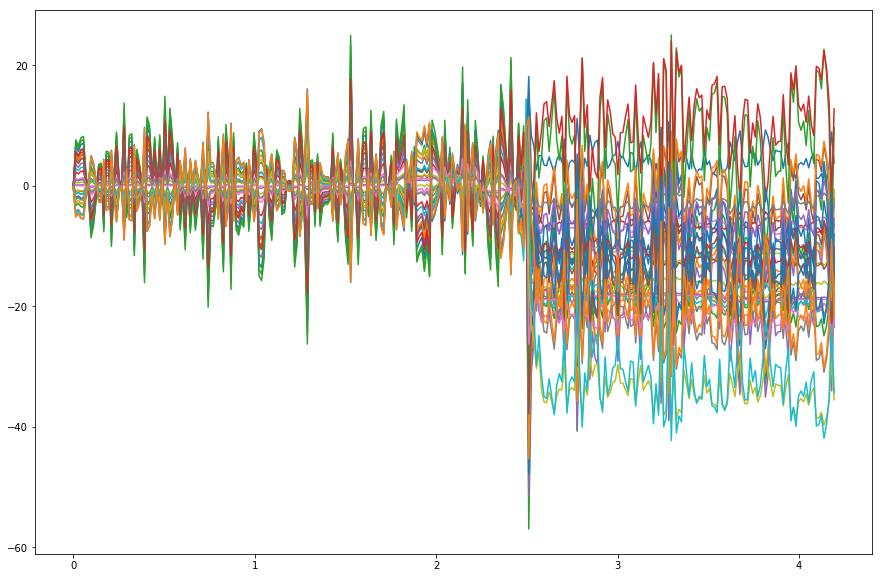

In [12]:
plt.figure(figsize=[15,10])
plt.plot(time, ROIs_filtered[:,:])

In [86]:
def manual_select():
    nb = input('Enter one or more sources number (separate numbers by "," if number of sources > 1): ')
#     print(nb.find(','))
    selected_source_idx = []
    if nb.find(',')==-1: #Single source selected
        try:
            number = int(nb)
#             print('number',number)
            selected_source_idx.append(number)
        except ValueError:
            print("Invalid number")
    else:

        nb = nb.replace(" ","")
        commas_idx = []
        import re
        for m in re.finditer(',', nb):
            commas_idx.append(m.start())
#         print('commas',commas_idx)
        try:
            number = int(nb[:commas_idx[0]])
#             print('number',number)
            selected_source_idx.append(number)
#             print('selected_source',selected_source_idx)
            for i in range(len(commas_idx)):
#                 print('i',i)
                if i==len(commas_idx)-1:
                    number = int(nb[commas_idx[i]+1:])
                else:
#                     print('bla',nb[commas_idx[i]+1:commas_idx[i+1]])
                    number = int(nb[commas_idx[i]+1:commas_idx[i+1]])
#                 print('numberrr',number)
                selected_source_idx.append(number)
#                 print('selected_source',selected_source_idx)
        except ValueError:
            print("Invalid number list")
    return(selected_source_idx)
            

In [92]:
a = manual_select()
print(a)
print('aaaaaaaaaaaaaaaaaaaaa')

Enter one or more sources number (separate numbers by "," if number of sources > 1): 2, 3, 4 
[2, 3, 4]
aaaaaaaaaaaaaaaaaaaaa


In [89]:
A = np.array([[2,4,6,8,10],[1,2,3,4,5],[3,6,9,12,15]])
print(A)
B = np.zeros_like(A)
idxs = np.array([1,3])
B[:,idxs] = A[:,idxs]
print(B)

[[ 2  4  6  8 10]
 [ 1  2  3  4  5]
 [ 3  6  9 12 15]]
[[ 0  4  0  8  0]
 [ 0  2  0  4  0]
 [ 0  6  0 12  0]]


In [20]:
s = 'js$d d'

In [22]:
'$' in s        # found


True

In [23]:
'$' not in s    # not found



False

In [24]:
# original answer given, but less Pythonic than the above...
s.find('$')==-1 # not found


False

In [25]:
s.find('$')!=-1 # found

True

In [29]:
b = s.find('d',index)
print(b)

NameError: name 'index' is not defined

In [30]:
index = s.find('ll', index)

NameError: name 'index' is not defined

In [35]:
import re
text = 'AllowedHelloHollow'
text = text.replace(" ","")
print(text)
for m in re.finditer('ll', text):
    print('ll found', m.start(), m.end())

AllowedHelloHollow
ll found 1 3
ll found 9 11
ll found 14 16


In [27]:
pattern = re.compile(r'\d\$,')
if pattern.findall(s):
    print('Found')
else:
    print('Not found')

NameError: name 're' is not defined